## What are our goals using the extracted dataset?

1. Find a way to read data from json and put it in pandas DataFrame so we can work easier with it
2. Extract important data insights about how our page works: brainstorm what kind of insights do we need, then analyze the data on a code level and see what else we can get
3. Create visuals that will help us easier see our discoveries (perhaps here we can select the 10 most important insights found at step 2)
4. Combine our DataFrames such that we will be able to extract what data we needed for our predictions: use created_date and start_date of events and created_date of posts to associate how many and what kind of posts were made by our page to promote the event. In this step we will manually remove events that were not an improv show and posts that were not related to an upcoming show. We will come up with a final DataFrame that will encapsulate all that we will need for our predictions.
5. Feature engineering
6. Learn how to predict two target variables at once (if possible); if this is not possible, develop 2 separate models to predict attending_count and interested_count from events based on the features that we obtained in step 5.
7. Learn how to run a server and have a frontend so that we can introduce test data into our models and see the results. This would be the end goal of the project: what it is that we can do as online 'marketing' so that we can attract as many spectators to our shows as we can?
8. Conclusion and next steps

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json

### 1. Reading json data into DataFrames

We have our data into 4 different files: event_entries.json, feed_entries.json, tagged_entries.json, visitor_posts_entries.json
All the data is in json format: each file contains a list of json objects. We want to convert these into DataFrames. Each missing value should be signaled by a null value with which we will deal in the feature engineering step.

It looks like it is very easy to get these by using the [pd.read_json()](https://pandas.pydata.org/docs/reference/api/pandas.read_json.html) method.

In [2]:
events_df = pd.read_json('data/event_entries.json', orient='records')
#events_df.head(30)

In [3]:
posts_df = pd.read_json('data/feed_entries.json', orient='records')
#posts_df.head(30)

In [4]:
tagged_df = pd.read_json('data/tagged_entries.json', orient='records')
#tagged_df.head(30)

In [5]:
visitor_posts_df = pd.read_json('data/visitor_posts_entries.json', orient='records')
#visitor_posts_df.head(30)

### 2. What kind of insights do we expect (brainstorm) + EDA

- Number of improv events vs number of workshop events
- Top 5 posts that got the most likes
- Top 5 posts that got the most shares
- How many people click on 'going', 'interested' on average per event
- Average number of likes per status type of posts
- Average number of attending/interested per place
- Number of times we did shows per place
- Attending count per season
- Number of total event responders (interested + going) correlated to number of days between event creation and event start date
- Posts that were 'popular' (=more people are engagin with the post than they are not)
- noreply_counts statistics (people that were invited to the event and did not respond)
- Most popular visitor posters
- Like per status_type category (average)
- Total number of events per season / total number of attending per season / total number of interested per season

These are the kind of insights we can see now. Below we will add other insights if the code will inspire us to do so.

- Average attending/interested per season of years

In [6]:
# Number of workshops vs shows
total_number_events = events_df.shape[0]
number_workshop_events = events_df.loc[(events_df['name'].str.contains('Unscript')) | (events_df['name'] == 'IMPROVara')].shape[0]
number_show_events = total_number_events - number_workshop_events
#number_show_events

In [7]:
# By looking at many rows of feed_entries_df, we can see that we have gotten from the API posts 
# that were not made by our page, but by one of our admins on their account. 
# We can see that these posts have a null 'is_popular' field.
# Let's see if our guess is true and look at many of these posts

posts_without_is_popular = posts_df.loc[posts_df['is_popular'].isnull()]
#posts_without_is_popular

# Indeed, after checking what we have in 'tagged_df' and 'visitor_posts_df' we can see that we have the same number of rows
# and the same 20 first entries. We can conclude that the posts which do not have any value in the 'is_popular' field
# are actually posts made by others in which our page was tagged.

We are on the right track. To make our jobs easier, let's combine these 3 DataFrames so that we can have all the data into just one.
So we will take the posts without 'is_popular' field and combine them with tagged_df and visitor_posts_df and we will name them visitor_posts and we will retain the next fields: 
- created_time(=tagged_time) 
- status_type 
- shares 
- likes
- story(from the visitor_posts_df)
- message

After playing a bit with the data sets, we can see that the visitor_posts match with the posts_without_is_popular 1 on 1.
However, the posts from tagged do not, even though they have the same number of rows.
After rechecking all the fields that these posts provide us, we can conclude that because we can see which are the visitor posts right off the feed_entries.json file, we can get rid of the tagged_df and visitor_posts_df.
We shall name the posts_df entries without an is_popular value visitor_posts and the other entries page_posts (denoting taht these were posts created from the page)

In [8]:
# Create the visitor_posts
visitor_posts = posts_without_is_popular[['message', 'created_time', 'status_type', 'shares', 'likes']]

In [9]:
print(visitor_posts.shape)
visitor_posts.head()

(89, 5)


,message,created_time,status_type,shares,likes
6,Pentru cei care ma intreaba de unde am inceput...,2022-03-17 12:52:04+00:00,mobile_status_update,NaN,15
12,"Mulțam fain, Roma!\nMă întorc că Improbabilii ...",2022-03-14 12:02:28+00:00,added_photos,NaN,15
17,Pe scenă e libertate și fericire pură alături ...,2022-02-23 16:05:49+00:00,added_photos,NaN,61
18,Primul spectacol Improbabilii din acest an🎭,2022-02-19 14:19:09+00:00,added_photos,NaN,61
25,Ce locuri știți în Cluj in care se pot organiz...,2021-12-07 17:35:34+00:00,mobile_status_update,NaN,4


In [10]:
# Drop posts that were not created by our page
posts_df = posts_df.dropna(subset=['is_popular'])
posts_df.shape

(139, 7)

In [11]:
top_5_page_posts_likes = posts_df.sort_values(by='likes', ascending=False).head()
top_5_page_posts_likes

,id,created_time,is_popular,message,status_type,shares,likes
116,1.581916e+31,2019-05-29 13:45:44+00:00,0.0,"La început a fost avântul. Până când, într-o z...",added_photos,NaN,110
205,1.581916e+31,2018-11-17 16:38:27+00:00,0.0,Creativitate și energie molipsitoare la Confer...,added_photos,3.0,107
47,1.581916e+31,2020-03-08 17:57:45+00:00,0.0,"De Ziua Femeii, improvizăm o felicitare cu ace...",added_photos,NaN,100
56,1.581916e+31,2020-02-13 07:49:53+00:00,0.0,Am vorbit despre 👉UnscriptEd 2 - Începători - ...,added_photos,NaN,97
19,1.581916e+31,2022-02-15 15:09:03+00:00,0.0,"Azi îi urăm ""La mulți ani!"" colegei noastre pr...",added_photos,NaN,93


In [12]:
top_5_user_posts_likes = visitor_posts.sort_values(by='likes', ascending=False).head()
top_5_user_posts_likes

,message,created_time,status_type,shares,likes
170,Așa arată fericirea pt. mine: Trupa Improbabilii,2019-02-19 18:23:23+00:00,added_photos,NaN,422
189,"Improbabilii ""It's improvisation, not showbiz ...",2018-11-24 13:36:51+00:00,added_photos,NaN,225
105,It is your duty in life to save your dream. Wi...,2019-07-03 08:44:51+00:00,added_photos,NaN,184
137,"Happiness is not a final destination, it is th...",2019-04-17 13:55:21+00:00,added_photos,NaN,162
147,Chiar dacă am luat-o pe drumuri diferite (spor...,2019-03-31 06:13:32+00:00,added_photos,4.0,158


In [13]:
top_5_posts_shares = posts_df.sort_values(by='shares', ascending=False).head()
top_5_posts_shares

,id,created_time,is_popular,message,status_type,shares,likes
191,1.581916e+31,2018-11-21 20:46:44+00:00,0.0,Vă așteptăm cu un nou Spectacol de improvizați...,added_video,15.0,42
174,1.581916e+31,2019-02-16 15:00:01+00:00,0.0,"Se ia o scenă, apoi se reia scena, apoi se mai...",added_video,9.0,21
211,1.581916e+31,2018-10-31 08:04:52+00:00,0.0,"De Halloween, postăm un video improvizat. Tema...",added_video,8.0,44
148,1.581916e+31,2019-03-28 18:00:13+00:00,0.0,Ai auzit un fluierat nefiresc în ultimul timp?...,added_video,8.0,81
139,1.581916e+31,2019-04-12 16:57:31+00:00,0.0,Vii seara obosit de muncă de pe ogor și acasă ...,added_video,8.0,37


In [14]:
# Let's further get just the show events and calculate average attendance and interested counts
show_events = events_df.loc[~(events_df['name'].str.contains('Unscript')) & ~(events_df['name'] == 'IMPROVara')]

# Another thing we want to do is we want to drop the current show as it is not relevant for the statistics
show_events = show_events.drop(0)

average_attending_count = show_events['attending_count'].mean()
average_interested_count = show_events['interested_count'].mean()
print("Average attending = ", average_attending_count, "; Average interested = ", average_interested_count)

Average attending =  41.3 ; Average interested =  189.05


In [15]:
# The average number of likes per status type of post
average_likes_per_status_type_of_post = posts_df.groupby(by='status_type').mean().drop(columns='id')
average_likes_per_status_type_of_post

# The average number of attending/interested per place
show_events.loc[(show_events['place'] == 'Cantina Campus Hașdeu - Sala C4') 
                | (show_events['place'] == 'OSUBB Cluj-Napoca'), 'place'] = 'Campus Hasdeu'
average_attending_interested_per_place = show_events.groupby(by='place').mean().drop(columns='id')

# Number of shows per place
number_of_shows_per_place = show_events.groupby(by='place').count().rename(columns={'attending_count': 'count'})['count']
number_of_shows_per_place

place
Campus Hasdeu                    3
Campus USAMV                     1
Centrul de Creație Maidan        2
Downtown Garden                  1
Flying Circus Cluj               1
Londoner Pub                     1
Parcul Central Cluj-Napoca       1
Rounders Sports - Bar & Grill    1
Urania Palace                    9
Name: count, dtype: int64

In order to get number of attendees per season, we will need to work with dates. Therefore, this is a good time to update our data frames and transform the dates from string to a more useful data type.

In [16]:
#show_events['start_time']

In [17]:
#show_events['created_time']

It looks like the created time is already of type datetime. We will just need to get rid of the timezone.
As for the start_time, we need to convert it to datetime from string.

In [18]:
# Format start_time
formatted_start_times = pd.to_datetime(show_events['start_time'], format="%Y-%m-%dT%H:%M:%S%z").values
for i in range(len(formatted_start_times)):
    formatted_start_times[i] = formatted_start_times[i].replace(tzinfo=None)
    
show_events['start_time'] = formatted_start_times
#print(show_events['start_time'])

In [19]:
import datetime

def format_created_time(dataframe):
    dataframe['created_time'] = dataframe['created_time'].dt.tz_localize(None)
    delta = datetime.timedelta(hours=2)
    dataframe['created_time'] = dataframe['created_time'] + delta

# Format created_time
format_created_time(show_events)
#show_events['created_time']

In [20]:
def get_season(date_entry):
    season = None
    if date_entry.month in [12, 1, 2]:
        season = 'winter'
    elif date_entry.month in [3, 4, 5]:
        season = 'spring'
    elif date_entry.month in [6, 7, 8]:
        season = 'summer'
    else:
        season = 'fall'
    return season

# Get attending count per season
seasons = show_events['start_time'].apply(get_season).rename('season')
events_and_seasons = pd.concat([show_events, seasons], axis=1)
mean_attendance_by_season = events_and_seasons.groupby(by='season').mean()
number_of_events_per_season = events_and_seasons.groupby(by='season').count()['id'].rename('count')
number_of_events_per_season

season
fall      6
spring    6
summer    3
winter    5
Name: count, dtype: int64

In [21]:
# Get event responders corresponding to days of promoting
show_events['days_of_promoting'] = (show_events['start_time'] - show_events['created_time']).dt.days
#show_events

In [22]:
# Find if there is a correlation between number of days to promote an event and engagements

correlation_matrix_attending_interested_promoting = show_events[['attending_count', 'interested_count', 'days_of_promoting']].corr()
total_engage = show_events['attending_count'] + show_events['interested_count']
correlation_matrix_total_engage_promoting = total_engage.corr(show_events['days_of_promoting'])

#correlation_matrix_attending_interested_promoting

We can clearly see that there is a big positive correlation: the more days of promoting => the more people attending/interested

In [23]:
# Average engagements per days of promoting
average_engagements_per_days_of_promoting = show_events.groupby(by='days_of_promoting').mean()[['attending_count', 'interested_count', 'noreply_count']]
number_of_days_of_promoting_classes = show_events.groupby(by='days_of_promoting').count()['id'].rename('count')
average_engagements_per_days_of_promoting = pd.concat([average_engagements_per_days_of_promoting, number_of_days_of_promoting_classes], axis=1)
average_engagements_per_days_of_promoting

,attending_count,interested_count,noreply_count,count
days_of_promoting,,,,
5,53.00,187.000000,426.0,1
6,39.50,136.000000,953.5,2
7,21.00,54.000000,1158.0,1
8,37.00,117.000000,1063.0,1
9,33.50,169.500000,1010.0,2
10,40.00,192.333333,1002.0,3
11,33.00,158.000000,1157.5,2
12,30.50,170.500000,891.0,2
13,47.25,216.750000,1029.0,4


In [24]:
import dataframe_image as dfi

# Save image to use for presentation later
dfi.export(average_engagements_per_days_of_promoting, 'Presentation/AverageEngagementPerDaysOfPromoting.png')

In [25]:
# Posts that were popular: Whether the post is popular. 
# Based on whether the total actions as a percentage of reach exceeds a certain threshold.
popular_posts = posts_df.loc[posts_df['is_popular'] == 1]

In [26]:
# noreply_count statistics
noreply_count_statistics = show_events['noreply_count'].describe()
#noreply_count_statistics

In [27]:
# Likes per status type category
likes_per_status_type_page_posts = posts_df.groupby(by='status_type').mean()['likes']
#likes_per_status_type_page_posts

In [28]:
likes_per_status_type_visitor_posts = visitor_posts.groupby(by='status_type').mean()['likes']
#likes_per_status_type_visitor_posts

In [29]:
total_attending_and_interested_per_season = events_and_seasons[['attending_count', 'interested_count', 'season']].groupby(by='season').sum()
number_of_events_per_season = events_and_seasons.groupby(by='season').count()['id'].rename('count')
total_attending_and_interested_per_season = pd.concat([total_attending_and_interested_per_season, number_of_events_per_season], axis=1)
#total_attending_and_interested_per_season

In [30]:
# Average attending/interested per season of years
years = show_events['start_time'].dt.year.rename('year')
events_and_seasons_and_years = pd.concat([show_events, seasons, years], axis=1)
number_shows_per_season_of_year = events_and_seasons_and_years.groupby(
    by=['year', 'season']).count()['id'].rename('number_of_events')
average_attending_interested_per_season_of_year = events_and_seasons_and_years.groupby(
    by=['year', 'season']).mean()[['attending_count', 'interested_count']].reset_index(level=[1])
average_attending_interested_per_season_of_year

# Save image to use for presentation later
dfi.export(average_attending_interested_per_season_of_year, 'Presentation/AverageAttendingInterestedPerSeasonOfYear.png')

### 3. Create visuals & Presentation

For this part we will create some graphs using seaborn and matplotlib to further understand the data that we have
What would be interesting to see graphically:

- posts per event
- days_of_promoting against attending_count and interested_count
- graphs of likes for both page and visitor posts plotted against status_type (1 image per status_type)
- graphs of shares for both page and visitor posts plotted against status_type
- for page posts: plot day posted against likes
- for page posts: plot hour of day posted against likes
- shows per place
- shows per year

What I will also do here is to save in a text file all the relevant text data that can be presented to the 'stakeholders':
- number of show events total
- number of page posts
- top 5 posts with the most likes
- top 5 posts with the most shares
- posts that were 'popular'
- number of shows per day of week

For the first graph we will need to add two new fields to our show_events: page_posts and visitor_posts. These will be the posts created between created_time and start_time of the event. After finding these posts, we will manually go through them to make sure they are related to the event and then count them.

In [31]:
def find_entries_between_dates(dataframe, start, end):
    return dataframe.loc[(dataframe['created_time'] >= start) & (dataframe['created_time'] <= end)]

In [32]:
# Make sure we have the same time format for all our data sets
format_created_time(posts_df)
format_created_time(visitor_posts)

C:\Users\Andrei\AppData\Local\Temp\ipykernel_5068\2043853360.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_time'] = dataframe['created_time'].dt.tz_localize(None)
C:\Users\Andrei\AppData\Local\Temp\ipykernel_5068\2043853360.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['created_time'] = dataframe['created_time'] + delta


In [33]:
# Find page posts and visitor posts that were made in the interval of event creation and actual event start
suffix='.json'
for index, row in show_events.iterrows():
    start_time = row['start_time']
    created_time = row['created_time']
    page_event_posts = find_entries_between_dates(posts_df, created_time, start_time)
    visitor_event_posts = find_entries_between_dates(visitor_posts, created_time, start_time)
    prefix = "data/eventdata/" + str(index) + "_"
    page_event_posts.to_json(prefix + "page_event_posts" + suffix, indent=4, orient='records')
    visitor_event_posts.to_json(prefix + "visitor_event_posts" + suffix, indent=4, orient='records')

We will manually go through each file in eventdata and eliminate all the posts that are not related to the event or the posts which announce the show creation (we will not count that as promoting).
We will put the files in the folder *curated_eventdata*.

In [34]:
# Attach page_posts and visitor_posts to new dataframe created out of events_and_seasons_and_years
events_and_seasons_and_years['page_posts'] = 0
events_and_seasons_and_years['visitor_posts'] = 0
for index, row in events_and_seasons_and_years.iterrows():
    page_posts_file = open('data/curated_eventdata/' + str(index) + '_page_event_posts.json', 'r')
    number_of_page_posts = pd.read_json(page_posts_file, orient='records').shape[0]
    visitor_posts_file = open('data/curated_eventdata/' + str(index) + '_visitor_event_posts.json', 'r')
    number_of_visitor_posts = pd.read_json(visitor_posts_file, orient='records').shape[0]
    events_and_seasons_and_years.loc[index, 'page_posts'] = number_of_page_posts
    events_and_seasons_and_years.loc[index, 'visitor_posts'] = number_of_visitor_posts

events_and_seasons_and_years

,id,attending_count,created_time,interested_count,name,noreply_count,place,start_time,days_of_promoting,season,year,page_posts,visitor_posts
3,724511648706750,21,2022-03-11 20:44:08,54,SOLD OUT | Improv Show | Improbabilii,1158,Centrul de Creație Maidan,2022-03-19 18:00:00,7,spring,2022,4,1
4,1359389507872473,27,2022-02-06 16:16:52,114,SOLD OUT | Improv Show | Improbabilii,856,Centrul de Creație Maidan,2022-02-19 19:00:00,13,winter,2022,5,0
5,2339955582842474,24,2021-09-20 11:41:05,115,Improv Show | Improbabilii,1218,Londoner Pub,2021-09-30 20:00:00,10,fall,2021,3,0
6,361726915423213,37,2021-08-12 14:01:58,117,Improv Show | Improbabilii,1063,Downtown Garden,2021-08-20 20:00:00,8,summer,2021,3,1
8,913922819089691,20,2020-02-12 21:55:54,134,Improv Show | Improbabilii,840,Urania Palace,2020-02-22 19:00:00,9,winter,2020,2,2
9,107840077312020,32,2020-01-18 20:59:30,206,Improv Show | Improbabilii,1084,Urania Palace,2020-02-01 19:00:00,13,winter,2020,3,0
10,2562764223777863,32,2019-12-02 18:12:09,170,Improv Show | Improbabilii,836,Urania Palace,2019-12-14 19:00:00,12,winter,2019,3,0
11,400644930879296,33,2019-10-22 17:11:24,135,Improv Show | Improbabilii,934,Rounders Sports - Bar & Grill,2019-11-02 19:00:00,11,fall,2019,4,0
12,474487776471813,31,2019-10-06 15:27:00,122,Improv Show by Improbabilii - Săptămâna Bobocului,959,Campus Hasdeu,2019-10-12 18:30:00,6,fall,2019,2,2
14,363692410988203,48,2019-07-22 11:22:26,150,Spectacol de improvizație caritabil @Family Fu...,948,Campus USAMV,2019-07-28 19:00:00,6,summer,2019,2,3


In [35]:
# Remove unused fields
useful_data = events_and_seasons_and_years.drop(columns=['created_time', 'name', 'id'])
useful_data['start_date'] = useful_data['start_time'].dt.date

In [36]:
# Plot days of promoting against page/visitor posts with number of attending/interested as hue
def bar_plot_with_bar_labels(y_column, file_prefix, file_suffix, labels, color):
    plt.figure(figsize=(10,8))
    ax = sns.barplot(x=useful_data['start_date'], y=y_column, color=color)
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('Event start time')
    ax.set_ylabel('Number of ' + file_prefix)
    ax.bar_label(ax.containers[0], labels=labels)
    ax.set_title("Number of " + file_prefix + " per event with attending count")

    plt.savefig('Presentation/' + file_prefix + 'PerEventWith' + file_suffix + 'Count.png')

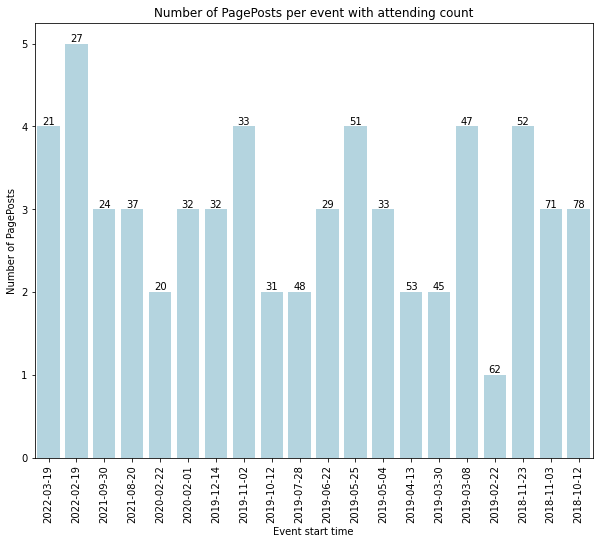

In [37]:
bar_plot_with_bar_labels(useful_data['page_posts'], file_prefix='PagePosts', 
                         file_suffix='Attending', labels=useful_data['attending_count'], color='lightblue')

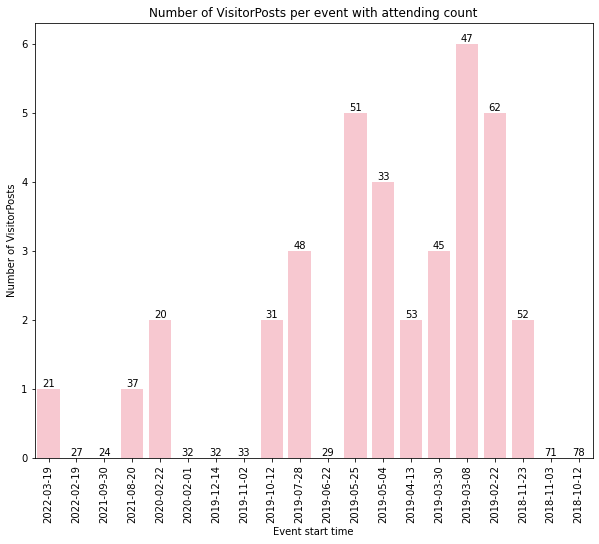

In [38]:
bar_plot_with_bar_labels(useful_data['visitor_posts'], file_prefix='VisitorPosts', 
                         file_suffix='Attending', labels=useful_data['attending_count'], color='pink')

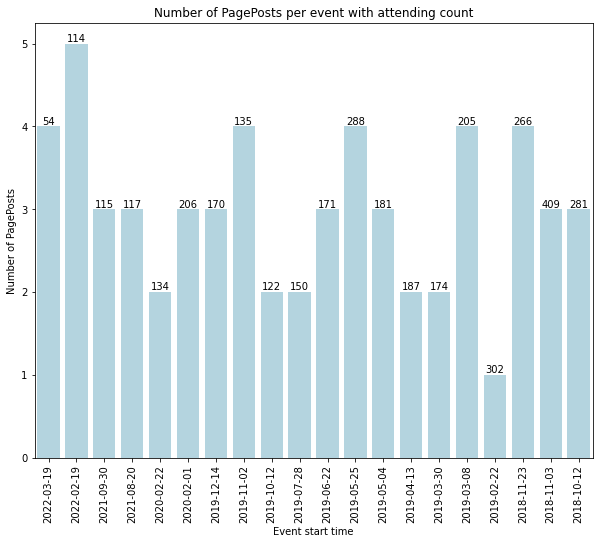

In [39]:
bar_plot_with_bar_labels(useful_data['page_posts'], file_prefix='PagePosts', 
                         file_suffix='Interested', labels=useful_data['interested_count'], color='lightblue')

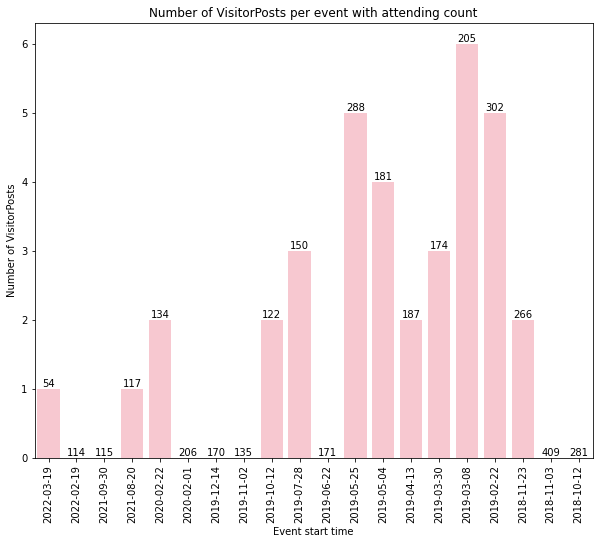

In [40]:
bar_plot_with_bar_labels(useful_data['visitor_posts'], file_prefix='VisitorPosts', 
                         file_suffix='Interested', labels=useful_data['interested_count'], color='pink')

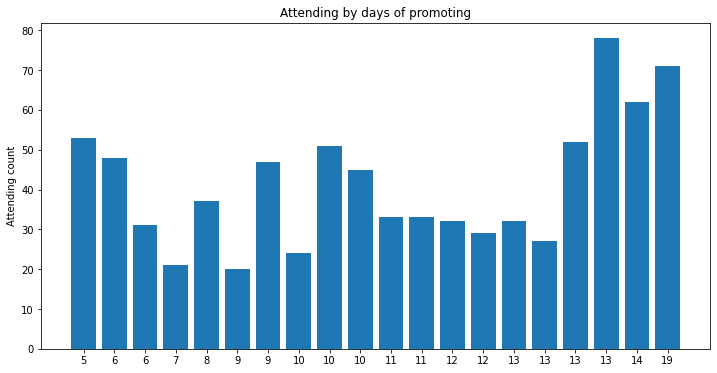

In [41]:
# See how much attending count correlated with days of promoting for each event
sorted_df = useful_data.sort_values(by='days_of_promoting')

x = np.arange(sorted_df.shape[0])

figure = plt.figure(figsize=(12, 6))
ax = figure.gca()
ax.bar(x, sorted_df['attending_count'], label='Attending')

ax.set_ylabel('Attending count')
ax.set_label("Days of promoting")
ax.set_title('Attending by days of promoting')
ax.set_xticks(x)
ax.set_xticklabels(sorted_df['days_of_promoting'])
plt.savefig('Presentation/AttendingByDaysOfPromoting.png')

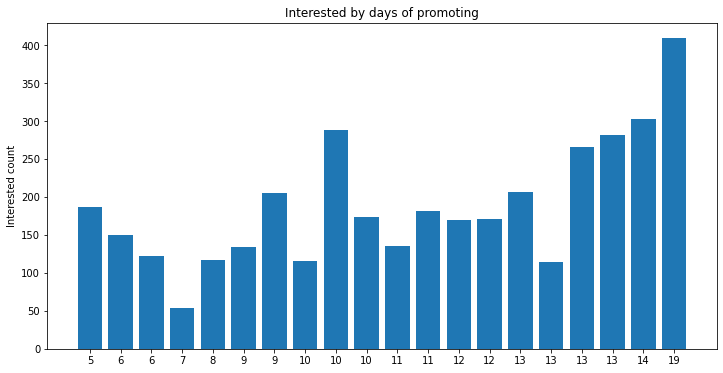

In [42]:
# See how much interested count correlated with days of promoting for each event
figure = plt.figure(figsize=(12, 6))
ax = figure.gca()
ax.bar(x, sorted_df['interested_count'], label='Interested')

ax.set_ylabel('Interested count')
ax.set_label("Days of promoting")
ax.set_title('Interested by days of promoting')
ax.set_xticks(x)
ax.set_xticklabels(sorted_df['days_of_promoting'])
plt.savefig('Presentation/InterestedByDaysOfPromoting.png')

In [43]:
# Subjectively define hour ranges to check if there is a difference between posting in different intervals
def get_hour_range(datetime_entry):
    time_string = None
    hour = datetime_entry.hour
    if hour < 12:
        time_string = 'morning'
    elif hour < 16:
        time_string = 'lunch'
    elif hour < 20:
        time_string = 'afternoon'
    else:
        time_string = 'night'
    return time_string

posts_df['hour_range'] = posts_df['created_time'].apply(get_hour_range)

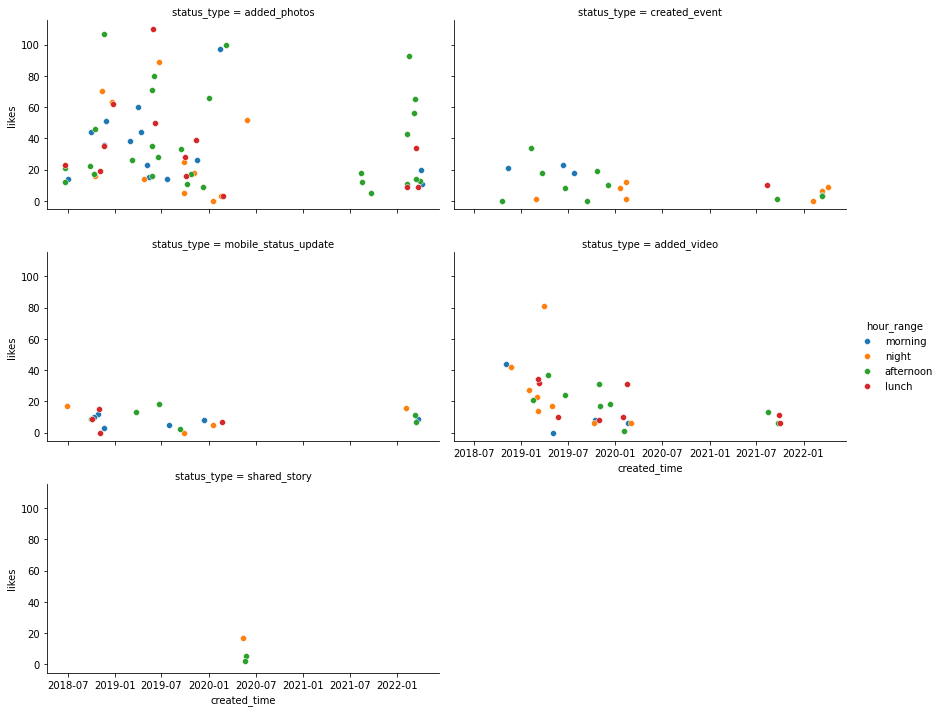

In [44]:
# Plot number of likes against every post type. Check if hour_range has any influence by using it as hue
g = sns.FacetGrid(posts_df, col="status_type", hue='hour_range', col_wrap=2)
g.figure.set_size_inches(12, 10)
g.map(sns.scatterplot, 'created_time', "likes")
g.add_legend()
g.savefig('Presentation/PagePostsLikesPerStatusType.png')

In [45]:
visitor_posts['hour_range'] = visitor_posts['created_time'].apply(get_hour_range)

C:\Users\Andrei\AppData\Local\Temp\ipykernel_5068\3088539215.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visitor_posts['hour_range'] = visitor_posts['created_time'].apply(get_hour_range)


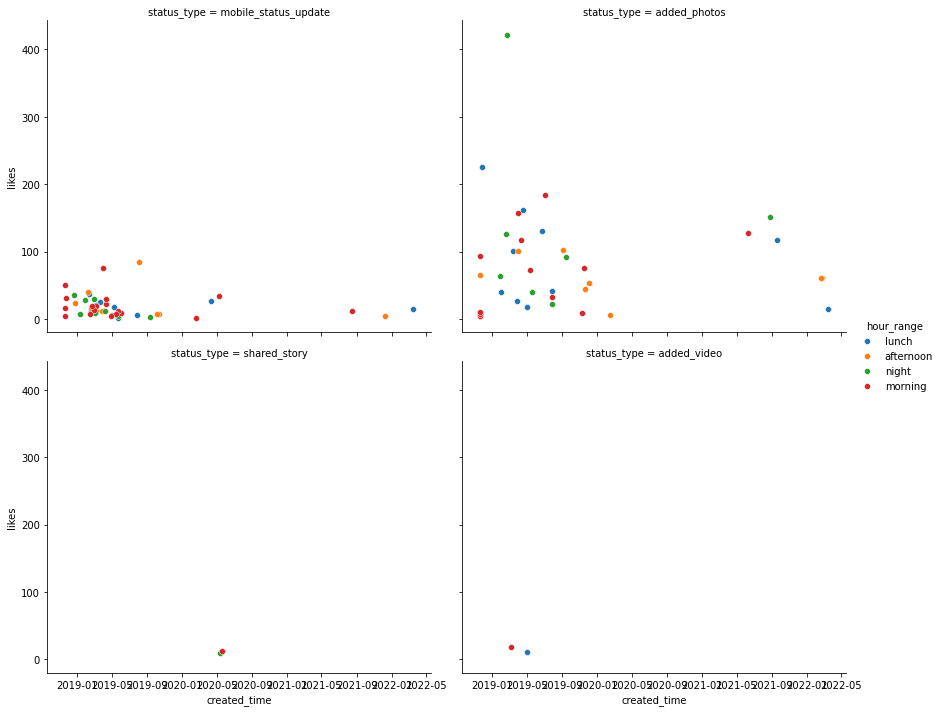

In [46]:
g = sns.FacetGrid(visitor_posts, col="status_type", hue='hour_range', col_wrap=2)
g.figure.set_size_inches(12, 10)
g.map(sns.scatterplot, 'created_time', "likes")
g.add_legend()
g.savefig('Presentation/VisitorsPostsLikesPerStatusType.png')

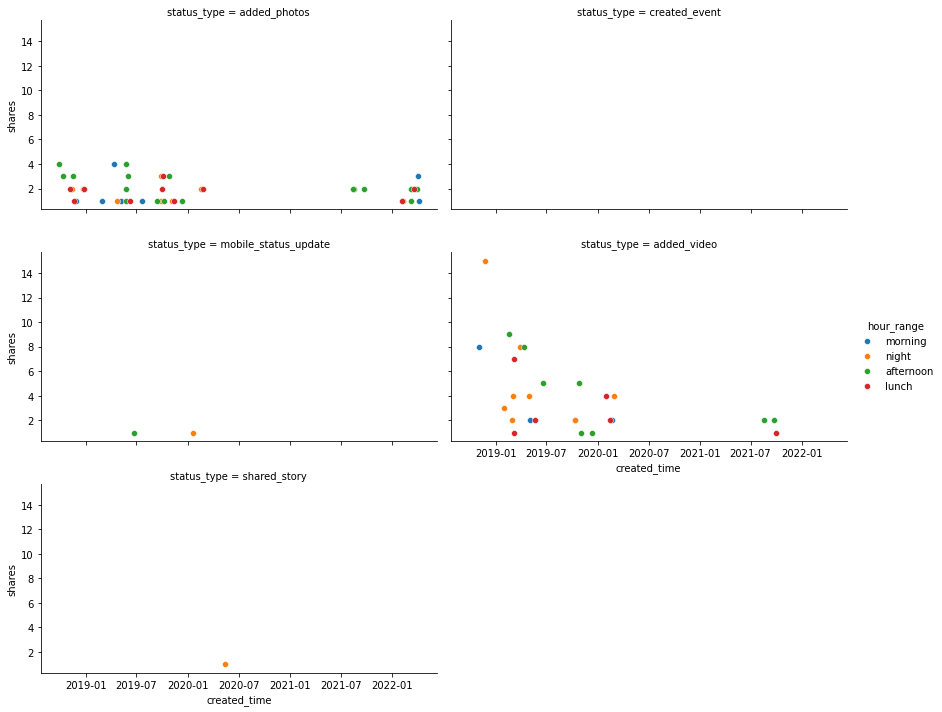

In [47]:
# Plot number of shares against every post type. Check if hour_range has any influence by using it as hue
g = sns.FacetGrid(posts_df, col="status_type", hue='hour_range', col_wrap=2)
g.figure.set_size_inches(12, 10)
g.map(sns.scatterplot, 'created_time', "shares")
g.add_legend()
g.savefig('Presentation/PagePostsSharesPerStatusType.png')

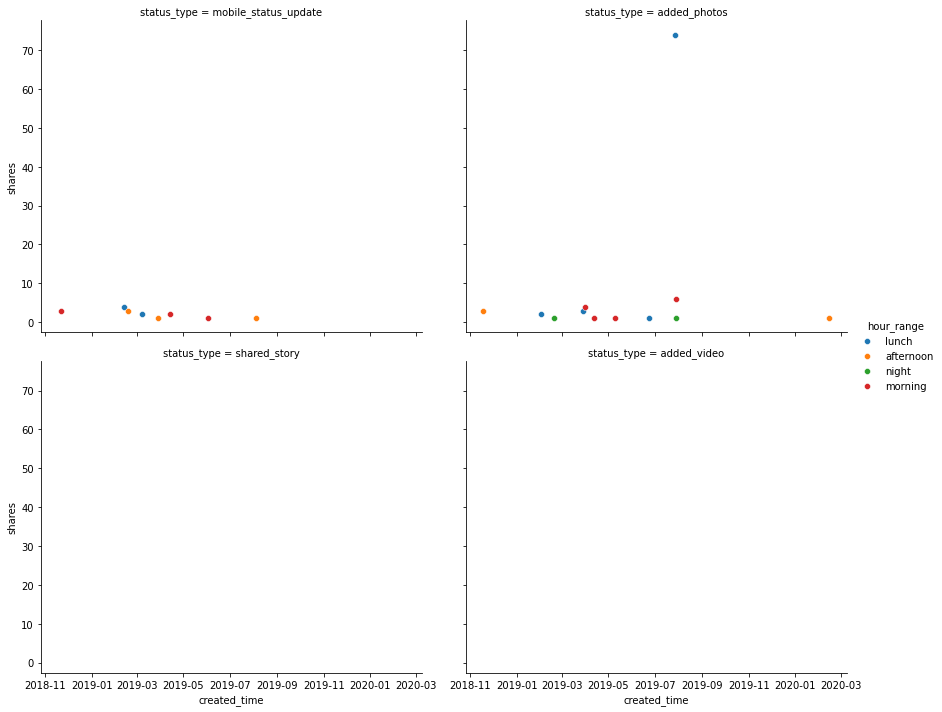

In [48]:
g = sns.FacetGrid(visitor_posts, col="status_type", hue='hour_range', col_wrap=2)
g.figure.set_size_inches(12, 10)
g.map(sns.scatterplot, 'created_time', "shares")
g.add_legend()
g.savefig('Presentation/VisitorsPostsSharesPerStatusType.png')

In [49]:
# Extract weekday to create visuals for weekday statistics
posts_df['weekday'] = posts_df['created_time'].dt.weekday
posts_df.head()

,id,created_time,is_popular,message,status_type,shares,likes,hour_range,weekday
0,1.581916e+31,2022-04-06 11:24:52,0.0,"Cum miercuri pică în mijlocul săptămânii, așa ...",added_photos,1.0,11,morning,2
1,1.581916e+30,2022-04-05 20:14:02,0.0,NaN,created_event,NaN,9,night,1
2,1.581916e+31,2022-04-05 11:16:26,0.0,Stați tunați că vine și evenimentul. În curând...,added_photos,3.0,20,morning,1
3,1.581916e+31,2022-03-30 18:35:14,0.0,O poveste în 4 de la ultimul nostru spectacol....,added_photos,2.0,13,afternoon,2
4,1.581916e+31,2022-03-23 10:38:11,0.0,"🔉 ANUNȚ DE INTERES GENERAL\n\nIeri, 3 dintre c...",mobile_status_update,NaN,9,morning,2


In [50]:
# Translate weekday number into English language
weekday_dict = {0: 'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
posts_df = posts_df.replace({'weekday': weekday_dict})
posts_df

,id,created_time,is_popular,message,status_type,shares,likes,hour_range,weekday
0,1.581916e+31,2022-04-06 11:24:52,0.0,"Cum miercuri pică în mijlocul săptămânii, așa ...",added_photos,1.0,11,morning,Wednesday
1,1.581916e+30,2022-04-05 20:14:02,0.0,NaN,created_event,NaN,9,night,Tuesday
2,1.581916e+31,2022-04-05 11:16:26,0.0,Stați tunați că vine și evenimentul. În curând...,added_photos,3.0,20,morning,Tuesday
3,1.581916e+31,2022-03-30 18:35:14,0.0,O poveste în 4 de la ultimul nostru spectacol....,added_photos,2.0,13,afternoon,Wednesday
4,1.581916e+31,2022-03-23 10:38:11,0.0,"🔉 ANUNȚ DE INTERES GENERAL\n\nIeri, 3 dintre c...",mobile_status_update,NaN,9,morning,Wednesday
...,...,...,...,...,...,...,...,...,...
223,1.581916e+31,2018-07-02 08:49:48,0.0,Pozele au fost preluate de pe pagina Toastmast...,added_photos,NaN,14,morning,Monday
224,1.581916e+31,2018-06-27 20:52:22,0.0,Mulțumim frumos Toastmasters Cluj pentru invit...,mobile_status_update,NaN,17,night,Wednesday
225,1.581916e+31,2018-06-21 12:47:05,0.0,Photos made by our friend Razvan Sicoe,added_photos,NaN,23,lunch,Thursday
226,1.581916e+31,2018-06-20 17:29:33,0.0,NaN,added_photos,NaN,21,afternoon,Wednesday


C:\Users\Andrei\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


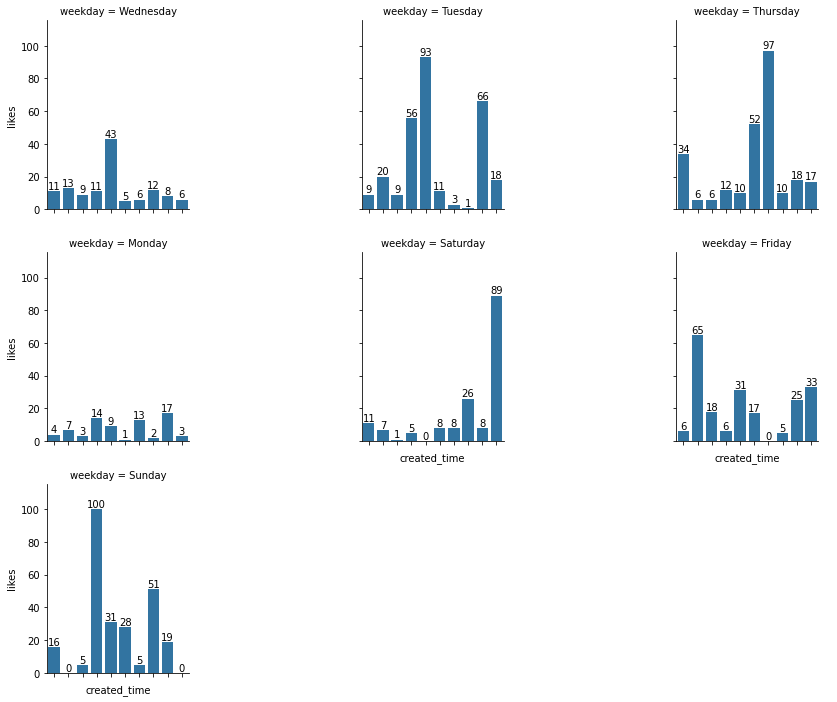

In [51]:
# Check number of likes per posts (divided into weekdays)
g = sns.FacetGrid(posts_df, col="weekday", col_wrap=3)
g.figure.set_size_inches(12, 10)
g.map(sns.barplot, 'created_time', "likes")
g.add_legend()
for ax in g.axes:
    ax.bar_label(ax.containers[0])
g.set_xticklabels([])
g.savefig('Presentation/PagePostsLikesPerWeekday.png')

C:\Users\Andrei\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


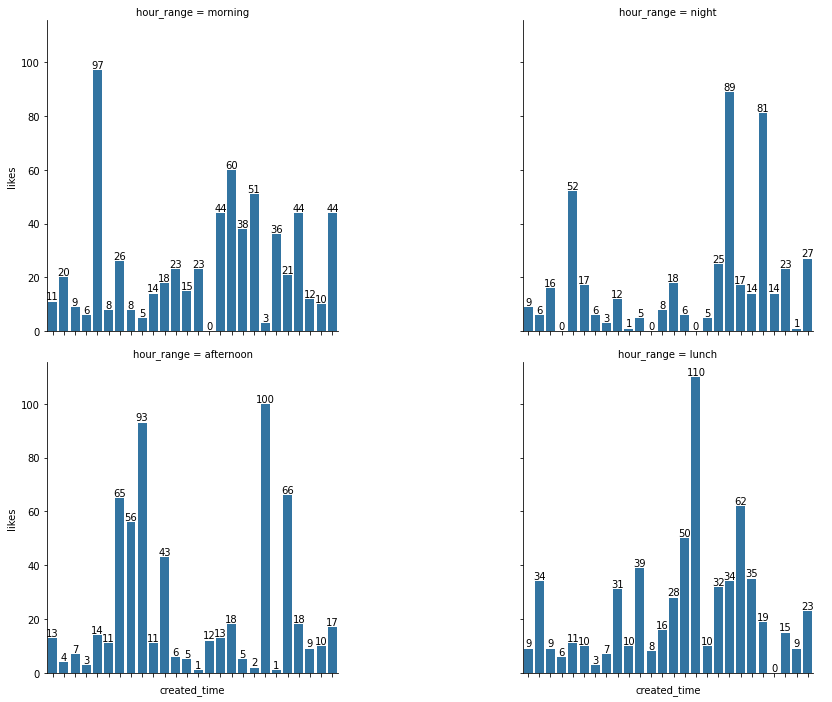

In [52]:
# Check number of likes per posts (divided into hour ranges)
g = sns.FacetGrid(posts_df, col="hour_range", col_wrap=2)
g.figure.set_size_inches(12, 10)
g.map(sns.barplot, 'created_time', "likes")
g.add_legend()
for ax in g.axes:
    ax.bar_label(ax.containers[0])
g.set_xticklabels([])
g.set_xlabels(None)
g.savefig('Presentation/PagePostsLikesPerHourRange.png')

In [53]:
shows_per_place = show_events.groupby('place').count()['created_time'].rename('Number of shows')

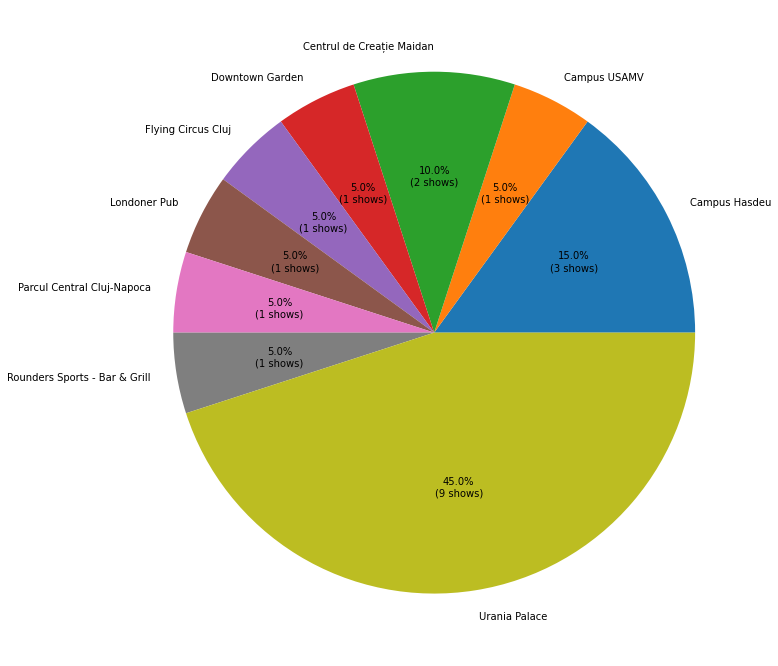

In [54]:
# Create pie visualization for show locations
def annotate_pie_chunks(pct, allvals):
    absolute = pct/100.*np.sum(allvals)
    return "{:.1f}%\n({:.0f} shows)".format(pct, absolute)

plt.figure(figsize=(12,12))
plt.pie(shows_per_place.values, labels=shows_per_place.index.values, autopct=lambda pct: annotate_pie_chunks(pct, shows_per_place.values))

plt.savefig('Presentation/ShowsPerPlace.png')

In [55]:
shows_per_year = events_and_seasons_and_years.groupby('year').count()['created_time'].rename('Number of shows')
shows_per_year

year
2018     3
2019    11
2020     2
2021     2
2022     2
Name: Number of shows, dtype: int64

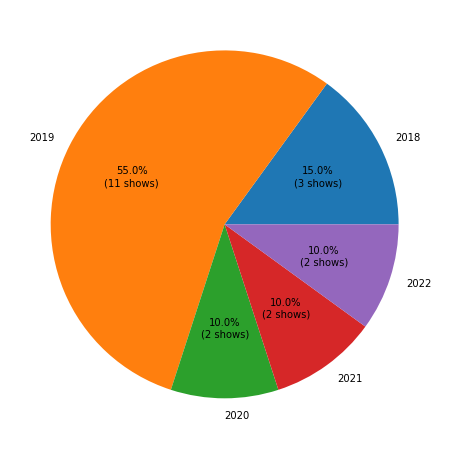

In [56]:
# Create pie visualization for number of shows per year
plt.figure(figsize=(8,8))
plt.pie(shows_per_year.values, labels=shows_per_year.index.values, autopct=lambda pct: annotate_pie_chunks(pct, shows_per_year.values))

plt.savefig('Presentation/ShowsPerYear.png')

In [57]:
# Previously created a text file PresentationData.txt in which I described the number of shows we had (for statistical accuracy only)
# since the facebook data only tells us what shows we hosted on our page
number_of_page_posts = posts_df.shape[0]
f = open('Presentation/PresentationData.txt', 'a')
f.write("\nNumber of page posts = " + str(number_of_page_posts) + " at date: " + datetime.datetime.now().ctime() + "\n")
f.close()

In [58]:
top_5_page_posts_likes.to_json('Presentation/Top5PagePostsByLikes.json', indent=4, orient='records')

In [59]:
top_5_posts_shares.to_json('Presentation/Top5PagePostsByShares.json', indent=4, orient='records')

In [60]:
popular_posts.to_json('Presentation/PopularPagePosts.json', indent=4, orient='records')

In [61]:
weekday_shows = show_events['start_time'].dt.weekday.rename('Weekday')
weekday_shows = weekday_shows.replace(to_replace=weekday_dict)
weekday_shows = weekday_shows.value_counts()

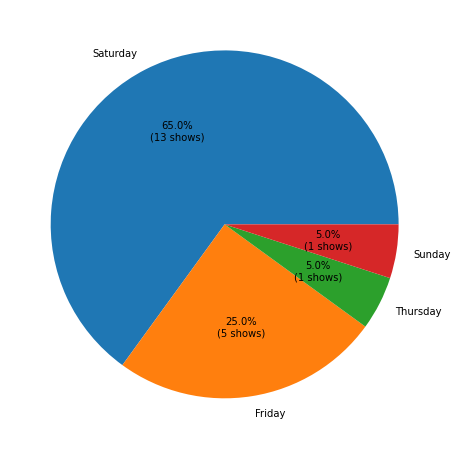

In [62]:
# Plot number of shows per weekday
plt.figure(figsize=(8,8))
plt.pie(weekday_shows.values, labels=weekday_shows.index.values, autopct=lambda pct: annotate_pie_chunks(pct, weekday_shows.values))

plt.savefig('Presentation/ShowsPerWeekday.png')

### 4 & 5. Feature engineering

This is the part where we will create our features that we will use for modeling \
What will be most useful in this endeavour will be the following features:
- days_of_promoting
- number_of_page_posts
- number_of_visitor_posts
- weekday (we need to see how skewed this field is and if it is relevant)
- number_of_unresponding_invited (this is highly correlated to how many people we invite to the event)
- to check: do we have different enough data to also include start hour?

We can create some simple visuals afterwards and see if we can come up with more features.
After this step we can begin modeling.

In [63]:
useful_data['start_hour'] = useful_data['start_time'].dt.hour

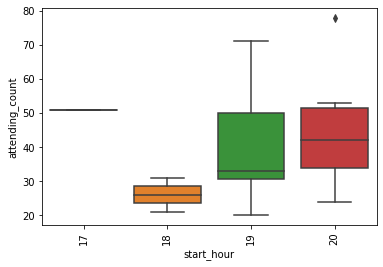

In [64]:
ax = sns.boxplot(x=useful_data['start_hour'], y=useful_data['attending_count'])
ax.tick_params(axis='x', rotation=90)

In [65]:
weekday_shows = useful_data['start_time'].dt.weekday.rename('Weekday')
weekday_shows = weekday_shows.replace(to_replace=weekday_dict)

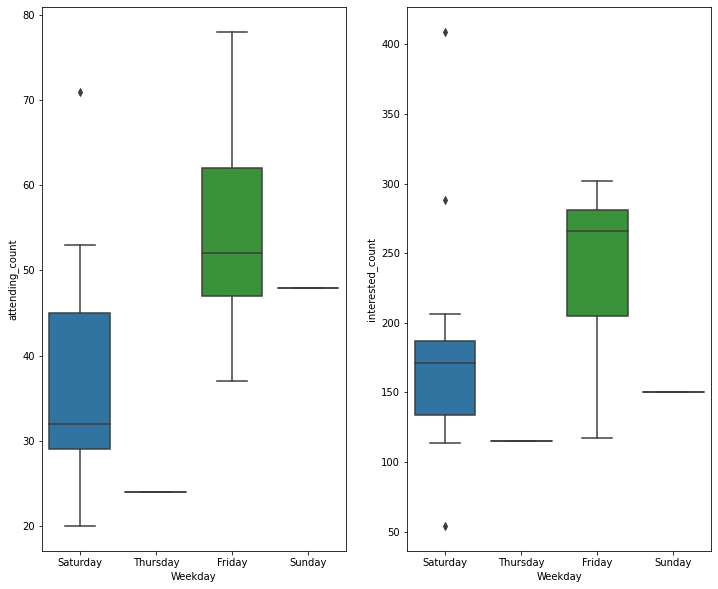

In [66]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 10)

sns.boxplot(x=weekday_shows, y=useful_data['attending_count'], ax=axes[0])

sns.boxplot(x=weekday_shows, y=useful_data['interested_count'], ax=axes[1])

plt.savefig('Presentation/AttendingInterestedPerWeekday.png')

Since most of our shows have been at 19 or 20, since these 2 are so close in numbers, we are better off if we do not include these into our model.

As for the weekday, we do not have enough data for all the days of the week, but we can see that usually friday is a better day for shows than saturday. Therefore, we will add two new fields: on_friday and on_saturday that will take values 1 if true and 0 if false.

In [67]:
# Reduce our data set to what we need
useful_data = useful_data.drop(columns=['place', 'start_time', 'season', 'year', 'start_date', 'start_hour'])

# Add weekdays to our dataset then create the two fields specified above
useful_data = pd.concat([useful_data, weekday_shows], axis=1)
useful_data['on_friday'] = 0
useful_data.loc[useful_data['Weekday'] == 'Friday', 'on_friday'] = 1
useful_data['on_saturday'] = 0
useful_data.loc[useful_data['Weekday'] == 'Saturday', 'on_saturday'] = 1
useful_data = useful_data.drop(columns='Weekday')

In [68]:
# Rename noreply_count column
useful_data = useful_data.rename(columns={'noreply_count':'invited_noreply'})
useful_data

,attending_count,interested_count,invited_noreply,days_of_promoting,page_posts,visitor_posts,on_friday,on_saturday
3,21,54,1158,7,4,1,0,1
4,27,114,856,13,5,0,0,1
5,24,115,1218,10,3,0,0,0
6,37,117,1063,8,3,1,1,0
8,20,134,840,9,2,2,0,1
9,32,206,1084,13,3,0,0,1
10,32,170,836,12,3,0,0,1
11,33,135,934,11,4,0,0,1
12,31,122,959,6,2,2,0,1
14,48,150,948,6,2,3,0,0


In [69]:
import os

models_folder = "models"

# Create folder if it does not exist
try: 
    os.mkdir(models_folder) 
except OSError as error: 
    print(error)

[WinError 183] Cannot create a file when that file already exists: 'models'


In [74]:
# Write the data into excel files to use it for manual checks later
useful_data.to_excel("data/improv_eventss.xls")

C:\Users\Andrei\AppData\Local\Temp\ipykernel_5068\3375363063.py:2: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  useful_data.to_excel("data/improv_eventss.xls")


In order for our models to make accurate predictions, we will need to scale the data.
This is so that the weights will not emphasize on one particular feature (here perhaps invited_noreply since it is so big compared to other).
This is why we will use MinMaxScaler for all our independent variables.

In [75]:
from sklearn.preprocessing import MinMaxScaler
import pickle

scaler = MinMaxScaler()
useful_data[['invited_noreply', 'days_of_promoting', 'page_posts', 'visitor_posts']] = scaler.fit_transform(
    useful_data[['invited_noreply', 'days_of_promoting', 'page_posts', 'visitor_posts']])

# Save scaler to use it later for predictions

pickle.dump(scaler, open(models_folder + "/" + 'scaler.p', 'wb'))

useful_data

,attending_count,interested_count,invited_noreply,days_of_promoting,page_posts,visitor_posts,on_friday,on_saturday
3,21,54,0.766492,0.142857,0.75,0.166667,0,1
4,27,114,0.450262,0.571429,1.00,0.000000,0,1
5,24,115,0.829319,0.357143,0.50,0.000000,0,0
6,37,117,0.667016,0.214286,0.50,0.166667,1,0
8,20,134,0.433508,0.285714,0.25,0.333333,0,1
9,32,206,0.689005,0.571429,0.50,0.000000,0,1
10,32,170,0.429319,0.500000,0.50,0.000000,0,1
11,33,135,0.531937,0.428571,0.75,0.000000,0,1
12,31,122,0.558115,0.071429,0.25,0.333333,0,1
14,48,150,0.546597,0.071429,0.25,0.500000,0,0


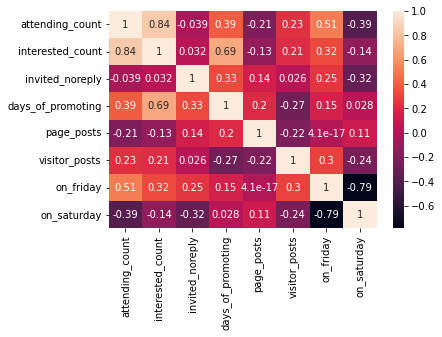

In [76]:
# Let's see a correlation map between our variables
sns.heatmap(useful_data.corr(), annot=True)
plt.show()

In [77]:
# Split data into independent and target variables
X_full = useful_data[['invited_noreply', 'days_of_promoting', 'page_posts', 'visitor_posts', 'on_friday', 'on_saturday']]
X_small = useful_data[['invited_noreply', 'days_of_promoting', 'page_posts', 'visitor_posts']]
y = useful_data[['attending_count', 'interested_count']]

Right off the bat we can see what we were expecting, the number of attendees is highly correlated to the number of interested people. 

Another interesting correlation is between days_of_promoting and both these counts. It would be natural to assume so, but now we also have the mathematical proof for it.

We will keep the features as they are for now, but when modeling, we might get rid of on_friday and on_saturday fields and see if we can achieve better accuracy.

### 6. Modeling

#### How to predict two output vairables

In our quest to find if this is possible, this [article](https://machinelearningmastery.com/multi-output-regression-models-with-python/) has been the most helpful.
It looks like we can use MultiOutputRegressor and RegressorChain both and see which one has the better result.
Since our dataset is very small, we will be able to run multiple models, therefore we can run both these methods, as well as what we mentioned before regarding removal of on_friday and on_saturday features.

#### Modeling

Another useful article that I learned from is [this](https://machinelearningmastery.com/process-for-working-through-machine-learning-problems/). Here it is suggested that we "spot-check" algorithms. And this is exactly what we'll do. We will prepare models from each class and for each of this model we will have 3 options based on modified hyperparameters.
Let us describe the process into steps so it can be easier seen:

1. Create list of models to use (since the dataset is small, it can be as big as we want)
2. For each model from the initial list, manually create 3 models with different hyperparameters. This means that instead of n models that we had in our list initially, we will have (approximately) 3*n models.
3. Using the MultiOutputRegressor and RegressorChain, get the top10 models for each method (total of 20 models).
4. Manually see what classes these belong to. Then we will create a new list of models consisting of all models belonging to classes of regressor in the 2 top10s.
5. Repeat process of step3.
6. Out of these 20 models (might be the case that we have repeating ones), select top5 regressors.
7. Using GridSearch, fine tune these 5 models.
8. After fine tuning them, also use voting ensembles to compare results.
9. Select the model to use for predictions.

Since we have big values for interested_count and attending_count, we will use 'neg_root_mean_squared_error' as a scoring parameter.

In [78]:
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, PassiveAggressiveRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# In order to preserve result truth when comparing algorithms, we will use the same random state
RANDOM_STATE = 7

# List initial models
initial_models = [LinearRegression(), Ridge(random_state=RANDOM_STATE), SGDRegressor(random_state=RANDOM_STATE),
                 PassiveAggressiveRegressor(random_state=RANDOM_STATE), SVR(), KNeighborsRegressor(),
                 GaussianProcessRegressor(random_state=RANDOM_STATE), DecisionTreeRegressor(random_state=RANDOM_STATE),
                 BaggingRegressor(random_state=RANDOM_STATE), RandomForestRegressor(random_state=RANDOM_STATE),
                 AdaBoostRegressor(random_state=RANDOM_STATE), GradientBoostingRegressor(random_state=RANDOM_STATE),
                 MLPRegressor(random_state=RANDOM_STATE)]

In [79]:
# Testing models: after looking through documentation for each of the models, 
# we come up with 3 different sets of hyperparameters to use for testing

models_to_test = []

# Append linear models
models_to_test.extend([LinearRegression(), 
                       Ridge(random_state=RANDOM_STATE, alpha=0.2), 
                       Ridge(random_state=RANDOM_STATE, alpha=0.5), 
                       Ridge(random_state=RANDOM_STATE, alpha=0.8),
                       SGDRegressor(random_state=RANDOM_STATE, penalty='l2', alpha=0.0001),
                       SGDRegressor(random_state=RANDOM_STATE, penalty='l1', alpha=0.01),
                       SGDRegressor(random_state=RANDOM_STATE, penalty='l2', alpha=1),
                       PassiveAggressiveRegressor(random_state=RANDOM_STATE, C=1),
                       PassiveAggressiveRegressor(random_state=RANDOM_STATE, C=0.1),
                       PassiveAggressiveRegressor(random_state=RANDOM_STATE, C=10)
                      ])

# Append svm models
models_to_test.extend([
                       SVR(C=1, kernel='linear'),
                       SVR(C=1, kernel='rbf'),
                       SVR(C=1, kernel='sigmoid')
                      ])

# Append neighbors models
models_to_test.extend([
                       KNeighborsRegressor(n_neighbors=5),
                       KNeighborsRegressor(n_neighbors=1),
                       KNeighborsRegressor(n_neighbors=3)
                      ])

# Append gaussian models
models_to_test.extend([GaussianProcessRegressor(random_state=RANDOM_STATE)])

# Append tree models
models_to_test.extend([
                       DecisionTreeRegressor(random_state=RANDOM_STATE, splitter='best', criterion='squared_error'),
                       DecisionTreeRegressor(random_state=RANDOM_STATE, splitter='random', criterion='squared_error'),
                       DecisionTreeRegressor(random_state=RANDOM_STATE, splitter='best', criterion='friedman_mse')
                      ])

# Append ensemble models
models_to_test.extend([BaggingRegressor(random_state=RANDOM_STATE, n_estimators=10),
                       BaggingRegressor(random_state=RANDOM_STATE, n_estimators=100),
                       BaggingRegressor(random_state=RANDOM_STATE, n_estimators=350), 
                       RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=100, max_depth=None), 
                       RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=100, max_depth=2),
                       RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=300, max_depth=None),
                       AdaBoostRegressor(random_state=RANDOM_STATE, n_estimators=100),
                       GradientBoostingRegressor(random_state=RANDOM_STATE, n_estimators=100, learning_rate=0.1),
                       GradientBoostingRegressor(random_state=RANDOM_STATE, n_estimators=400, learning_rate=0.1),
                       GradientBoostingRegressor(random_state=RANDOM_STATE, n_estimators=100, learning_rate=0.001)
                      ])


# Append neural network models
models_to_test.extend([
                       MLPRegressor(random_state=RANDOM_STATE, hidden_layer_sizes=(100,)),
                       MLPRegressor(random_state=RANDOM_STATE, hidden_layer_sizes=(100,100)),
                       MLPRegressor(random_state=RANDOM_STATE, hidden_layer_sizes=(100,100,100))
                      ])

print("We have a total of {} models to test".format(len(models_to_test)))

We have a total of 33 models to test


In [80]:
from sklearn.multioutput import MultiOutputRegressor, RegressorChain

def get_multi_output_regressor_models(base_models):
    mor_models = []
    for model in base_models:
        mor_models.append(MultiOutputRegressor(model))
    return mor_models

def get_regressor_chain_models(base_models):
    rc_models = []
    for model in base_models:
        rc_models.append(RegressorChain(model, random_state=RANDOM_STATE))
    return rc_models

multi_output_regressor_models = get_multi_output_regressor_models(models_to_test)
regressor_chain_models = get_regressor_chain_models(models_to_test)

In [81]:
from sklearn.model_selection import cross_val_score

def get_results_dataframe(multi_output_models, X_train):
    multi_output_scores = {'estimator_name': [], 'score': [], 'parameters': []}
    
    for model in multi_output_models:
        if model.__class__.__name__ == 'MultiOutputRegressor':
            model_name = model.estimator.__class__.__name__
        else:
            model_name = model.base_estimator.__class__.__name__
        model_parameters = str(model.get_params())
        model_score = np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv=10, n_jobs=-1).mean())
        multi_output_scores['estimator_name'].append(model_name)
        multi_output_scores['score'].append(model_score)
        multi_output_scores['parameters'].append(model_parameters)
    
    return pd.DataFrame(multi_output_scores)

In [82]:
multi_output_df = get_results_dataframe(multi_output_regressor_models, X_full)
regressor_chain_df = get_results_dataframe(regressor_chain_models, X_full)

In [83]:
# Visually check results
multi_output_df.sort_values(by='score').head(10)

,estimator_name,score,parameters
16,GaussianProcessRegressor,43.329546,"{'estimator__alpha': 1e-10, 'estimator__copy_X..."
28,GradientBoostingRegressor,50.189719,"{'estimator__alpha': 0.9, 'estimator__ccp_alph..."
27,GradientBoostingRegressor,50.211772,"{'estimator__alpha': 0.9, 'estimator__ccp_alph..."
9,PassiveAggressiveRegressor,50.765447,"{'estimator__C': 10, 'estimator__average': Fal..."
1,Ridge,52.690358,"{'estimator__alpha': 0.2, 'estimator__copy_X':..."
20,BaggingRegressor,53.732618,"{'estimator__base_estimator': None, 'estimator..."
2,Ridge,54.337033,"{'estimator__alpha': 0.5, 'estimator__copy_X':..."
26,AdaBoostRegressor,54.971932,"{'estimator__base_estimator': None, 'estimator..."
21,BaggingRegressor,55.008204,"{'estimator__base_estimator': None, 'estimator..."
7,PassiveAggressiveRegressor,55.062795,"{'estimator__C': 1, 'estimator__average': Fals..."


In [84]:
# Visually check results
regressor_chain_df.sort_values(by='score').head(10)

,estimator_name,score,parameters
1,Ridge,52.690358,"{'base_estimator__alpha': 0.2, 'base_estimator..."
2,Ridge,54.337033,"{'base_estimator__alpha': 0.5, 'base_estimator..."
9,PassiveAggressiveRegressor,54.339569,"{'base_estimator__C': 10, 'base_estimator__ave..."
0,LinearRegression,55.565279,"{'base_estimator__copy_X': True, 'base_estimat..."
3,Ridge,56.207854,"{'base_estimator__alpha': 0.8, 'base_estimator..."
26,AdaBoostRegressor,57.910393,"{'base_estimator__base_estimator': None, 'base..."
23,RandomForestRegressor,59.003428,"{'base_estimator__bootstrap': True, 'base_esti..."
22,BaggingRegressor,59.334651,"{'base_estimator__base_estimator': None, 'base..."
21,BaggingRegressor,59.542347,"{'base_estimator__base_estimator': None, 'base..."
25,RandomForestRegressor,59.903540,"{'base_estimator__bootstrap': True, 'base_esti..."


In [85]:
# Let's also see what kind of results we have if we train on X_small
multi_output_small_df = get_results_dataframe(multi_output_regressor_models, X_small)
regressor_chain_small_df = get_results_dataframe(regressor_chain_models, X_small)

In [86]:
# Visually check results
multi_output_small_df.sort_values(by='score').head(10)

,estimator_name,score,parameters
7,PassiveAggressiveRegressor,49.447663,"{'estimator__C': 1, 'estimator__average': Fals..."
27,GradientBoostingRegressor,50.732546,"{'estimator__alpha': 0.9, 'estimator__ccp_alph..."
28,GradientBoostingRegressor,50.738559,"{'estimator__alpha': 0.9, 'estimator__ccp_alph..."
26,AdaBoostRegressor,50.885863,"{'estimator__base_estimator': None, 'estimator..."
1,Ridge,52.157615,"{'estimator__alpha': 0.2, 'estimator__copy_X':..."
9,PassiveAggressiveRegressor,52.432385,"{'estimator__C': 10, 'estimator__average': Fal..."
21,BaggingRegressor,53.618951,"{'estimator__base_estimator': None, 'estimator..."
23,RandomForestRegressor,53.630994,"{'estimator__bootstrap': True, 'estimator__ccp..."
0,LinearRegression,53.708343,"{'estimator__copy_X': True, 'estimator__fit_in..."
20,BaggingRegressor,53.766651,"{'estimator__base_estimator': None, 'estimator..."


In [87]:
# Visually check results
regressor_chain_small_df.sort_values(by='score').head(10)

,estimator_name,score,parameters
1,Ridge,52.157615,"{'base_estimator__alpha': 0.2, 'base_estimator..."
0,LinearRegression,53.708343,"{'base_estimator__copy_X': True, 'base_estimat..."
2,Ridge,54.117868,"{'base_estimator__alpha': 0.5, 'base_estimator..."
26,AdaBoostRegressor,55.825127,"{'base_estimator__base_estimator': None, 'base..."
3,Ridge,56.037780,"{'base_estimator__alpha': 0.8, 'base_estimator..."
20,BaggingRegressor,56.844098,"{'base_estimator__base_estimator': None, 'base..."
23,RandomForestRegressor,57.904034,"{'base_estimator__bootstrap': True, 'base_esti..."
25,RandomForestRegressor,58.283220,"{'base_estimator__bootstrap': True, 'base_esti..."
21,BaggingRegressor,58.310812,"{'base_estimator__base_estimator': None, 'base..."
22,BaggingRegressor,58.504330,"{'base_estimator__base_estimator': None, 'base..."


We can see that while the MultiOutputRegressor has better scores overall, the RegressionChain has the scores closer as values (std of error scores).
Because the next regressors had very good results: 
- GaussianProcessRegressor 
- PassiveAggressiveRegressor 
- GradientBoostingRegressor
- BaggingRegressor
- RandomForestRegressor
- Ridge
- AdaBoost
- KNeighbors \
we will take them and every regressor of the same class (excepting ones we have already tested here and are not amongst ones above) and do the exact same thing as in step 2: obtain 3 parameterized models out of each.
Again, this is possible due to our very small data set. If the dataset was bigger, we would experiment much less with these models.

After constructing these models and evaluating them, we will select all the models from top3 out of every estimation process (i.e. 3 from MultiOutputRegressor with X_full, 3 from MultiOutputRegressor with X_small, 3 from RegressionChain with X_full, 3 from RegressionChain with X_small).
We will then carefully fine-tune these models and select the best tuned 5.

In [88]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Lasso, ElasticNet, LassoLars, OrthogonalMatchingPursuit, BayesianRidge
from sklearn.linear_model import TweedieRegressor, HuberRegressor, QuantileRegressor
from sklearn.neighbors import RadiusNeighborsRegressor


models_to_test = []

# Append linear models
models_to_test.extend([LinearRegression(), 
                       Ridge(random_state=RANDOM_STATE, alpha=0.2), 
                       Ridge(random_state=RANDOM_STATE, alpha=0.5), 
                       Ridge(random_state=RANDOM_STATE, alpha=0.8),
                       Lasso(random_state=RANDOM_STATE, alpha=1),
                       Lasso(random_state=RANDOM_STATE, alpha=10),
                       Lasso(random_state=RANDOM_STATE, alpha=0.01),
                       LassoLars(random_state=RANDOM_STATE, alpha=1),
                       LassoLars(random_state=RANDOM_STATE, alpha=10),
                       LassoLars(random_state=RANDOM_STATE, alpha=0.01),
                       ElasticNet(random_state=RANDOM_STATE, alpha=1, l1_ratio=0.5),
                       ElasticNet(random_state=RANDOM_STATE, alpha=0.01, l1_ratio=0.5),
                       ElasticNet(random_state=RANDOM_STATE, alpha=1, l1_ratio=0.1),
                       OrthogonalMatchingPursuit(),
                       BayesianRidge(alpha_1 = 0.000001, alpha_2 = 0.000001, lambda_1 = 0.000001, lambda_2 = 0.000001),
                       BayesianRidge(alpha_1 = 0.001, alpha_2 = 0.001, lambda_1 = 0.001, lambda_2 = 0.001),
                       BayesianRidge(alpha_1 = 0.001, alpha_2 = 0.000001, lambda_1 = 0.001, lambda_2 = 0.000001),
                       TweedieRegressor(power=0, alpha=1),
                       TweedieRegressor(power=1, alpha=0.5),
                       TweedieRegressor(power=2, alpha=1),
                       HuberRegressor(alpha=0.0001, epsilon=1.35),
                       HuberRegressor(alpha=0.0001, epsilon=1.7),
                       HuberRegressor(alpha=0.01, epsilon=1.35),
                       QuantileRegressor(quantile=0.5, alpha=1.0),
                       QuantileRegressor(quantile=0.1, alpha=1.0),
                       QuantileRegressor(quantile=0.5, alpha=0.01),
                       PassiveAggressiveRegressor(random_state=RANDOM_STATE, C=1),
                       PassiveAggressiveRegressor(random_state=RANDOM_STATE, C=0.1),
                       PassiveAggressiveRegressor(random_state=RANDOM_STATE, C=10)
                      ])


# Append neighbors models
models_to_test.extend([
                       KNeighborsRegressor(n_neighbors=5),
                       KNeighborsRegressor(n_neighbors=1),
                       KNeighborsRegressor(n_neighbors=3),
                       RadiusNeighborsRegressor(radius=1),
                       RadiusNeighborsRegressor(radius=3),
                       RadiusNeighborsRegressor(radius=5)
                      ])

# Append gaussian models
models_to_test.extend([GaussianProcessRegressor(random_state=RANDOM_STATE),
                       GaussianProcessRegressor(random_state=RANDOM_STATE, alpha=0.000001),
                       GaussianProcessRegressor(random_state=RANDOM_STATE, alpha=0.01)
                      ])

# Append ensemble models
models_to_test.extend([BaggingRegressor(random_state=RANDOM_STATE, n_estimators=10),
                       BaggingRegressor(random_state=RANDOM_STATE, n_estimators=100),
                       BaggingRegressor(random_state=RANDOM_STATE, n_estimators=350), 
                       RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=100, max_depth=None), 
                       RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=100, max_depth=2),
                       RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=300, max_depth=None),
                       AdaBoostRegressor(random_state=RANDOM_STATE, n_estimators=100),
                       GradientBoostingRegressor(random_state=RANDOM_STATE, n_estimators=100, learning_rate=0.1),
                       GradientBoostingRegressor(random_state=RANDOM_STATE, n_estimators=400, learning_rate=0.1),
                       GradientBoostingRegressor(random_state=RANDOM_STATE, n_estimators=100, learning_rate=0.001),
                       HistGradientBoostingRegressor(random_state=RANDOM_STATE, max_iter=200, max_depth=None, loss='squared_error'),
                       HistGradientBoostingRegressor(random_state=RANDOM_STATE, max_iter=200, max_depth=3, loss='squared_error'),
                       HistGradientBoostingRegressor(random_state=RANDOM_STATE, max_iter=200, max_depth=None, loss='poisson')
                      ])

# Append XGB and LGBM
models_to_test.extend([XGBRegressor(random_state=RANDOM_STATE, n_estimators=100, max_depth = 3),
                       XGBRegressor(random_state=RANDOM_STATE, n_estimators=300, max_depth = 3),
                       XGBRegressor(random_state=RANDOM_STATE, n_estimators=100, max_depth = 6),
                       LGBMRegressor(random_state=RANDOM_STATE, n_estimators = 100, max_depth = 3),
                       LGBMRegressor(random_state=RANDOM_STATE, n_estimators = 100, max_depth = 1),
                       LGBMRegressor(random_state=RANDOM_STATE, n_estimators = 300, max_depth = 3)
                      ])

print("We have a total of {} models to test".format(len(models_to_test)))

C:\Users\Andrei\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


We have a total of 57 models to test


In [89]:
multi_output_regressor_models = get_multi_output_regressor_models(models_to_test)
regressor_chain_models = get_regressor_chain_models(models_to_test)

In [90]:
multi_output_df = get_results_dataframe(multi_output_regressor_models, X_full)
regressor_chain_df = get_results_dataframe(regressor_chain_models, X_full)

In [91]:
# Visually check results
multi_output_df.sort_values(by='score').head(10)

,estimator_name,score,parameters
36,GaussianProcessRegressor,43.304127,"{'estimator__alpha': 1e-06, 'estimator__copy_X..."
35,GaussianProcessRegressor,43.329546,"{'estimator__alpha': 1e-10, 'estimator__copy_X..."
37,GaussianProcessRegressor,48.145183,"{'estimator__alpha': 0.01, 'estimator__copy_X_..."
46,GradientBoostingRegressor,50.189719,"{'estimator__alpha': 0.9, 'estimator__ccp_alph..."
45,GradientBoostingRegressor,50.211772,"{'estimator__alpha': 0.9, 'estimator__ccp_alph..."
28,PassiveAggressiveRegressor,50.765447,"{'estimator__C': 10, 'estimator__average': Fal..."
52,XGBRegressor,51.343089,"{'estimator__objective': 'reg:squarederror', '..."
51,XGBRegressor,51.343321,"{'estimator__objective': 'reg:squarederror', '..."
1,Ridge,52.690358,"{'estimator__alpha': 0.2, 'estimator__copy_X':..."
53,XGBRegressor,52.709393,"{'estimator__objective': 'reg:squarederror', '..."


In [92]:
# Visually check results
regressor_chain_df.sort_values(by='score').head(10)

,estimator_name,score,parameters
22,HuberRegressor,47.989811,"{'base_estimator__alpha': 0.01, 'base_estimato..."
20,HuberRegressor,50.874505,"{'base_estimator__alpha': 0.0001, 'base_estima..."
7,LassoLars,52.221463,"{'base_estimator__alpha': 1, 'base_estimator__..."
1,Ridge,52.690358,"{'base_estimator__alpha': 0.2, 'base_estimator..."
25,QuantileRegressor,52.812621,"{'base_estimator__alpha': 0.01, 'base_estimato..."
4,Lasso,52.903070,"{'base_estimator__alpha': 1, 'base_estimator__..."
11,ElasticNet,53.233655,"{'base_estimator__alpha': 0.01, 'base_estimato..."
2,Ridge,54.337033,"{'base_estimator__alpha': 0.5, 'base_estimator..."
28,PassiveAggressiveRegressor,54.339569,"{'base_estimator__C': 10, 'base_estimator__ave..."
21,HuberRegressor,55.470037,"{'base_estimator__alpha': 0.0001, 'base_estima..."


In [93]:
multi_output_small_df = get_results_dataframe(multi_output_regressor_models, X_small)
regressor_chain_small_df = get_results_dataframe(regressor_chain_models, X_small)

In [94]:
# Visually check results
multi_output_small_df.sort_values(by='score').head(10)

,estimator_name,score,parameters
37,GaussianProcessRegressor,39.814787,"{'estimator__alpha': 0.01, 'estimator__copy_X_..."
26,PassiveAggressiveRegressor,49.447663,"{'estimator__C': 1, 'estimator__average': Fals..."
25,QuantileRegressor,49.511624,"{'estimator__alpha': 0.01, 'estimator__fit_int..."
45,GradientBoostingRegressor,50.732546,"{'estimator__alpha': 0.9, 'estimator__ccp_alph..."
46,GradientBoostingRegressor,50.738559,"{'estimator__alpha': 0.9, 'estimator__ccp_alph..."
44,AdaBoostRegressor,50.885863,"{'estimator__base_estimator': None, 'estimator..."
22,HuberRegressor,51.056011,"{'estimator__alpha': 0.01, 'estimator__epsilon..."
53,XGBRegressor,51.727003,"{'estimator__objective': 'reg:squarederror', '..."
1,Ridge,52.157615,"{'estimator__alpha': 0.2, 'estimator__copy_X':..."
11,ElasticNet,52.219972,"{'estimator__alpha': 0.01, 'estimator__copy_X'..."


In [95]:
# Visually check results
regressor_chain_small_df.sort_values(by='score').head(10)

,estimator_name,score,parameters
25,QuantileRegressor,47.286533,"{'base_estimator__alpha': 0.01, 'base_estimato..."
22,HuberRegressor,49.137865,"{'base_estimator__alpha': 0.01, 'base_estimato..."
20,HuberRegressor,51.219267,"{'base_estimator__alpha': 0.0001, 'base_estima..."
7,LassoLars,51.613073,"{'base_estimator__alpha': 1, 'base_estimator__..."
1,Ridge,52.157615,"{'base_estimator__alpha': 0.2, 'base_estimator..."
11,ElasticNet,52.226064,"{'base_estimator__alpha': 0.01, 'base_estimato..."
21,HuberRegressor,52.728981,"{'base_estimator__alpha': 0.0001, 'base_estima..."
4,Lasso,52.823240,"{'base_estimator__alpha': 1, 'base_estimator__..."
6,Lasso,53.622953,"{'base_estimator__alpha': 0.01, 'base_estimato..."
9,LassoLars,53.627783,"{'base_estimator__alpha': 0.01, 'base_estimato..."


It looks like we have some very good candidates for the next phase. As we said, we would look at top3 for each of the tops.
This will leave us with: GaussianProcessRegressor, GradientBoostingRegressor, PassiveAggressiveRegressor, QuantileRegressor, HuberRegressor and Ridge.

We will fine tune these 6 models and see which one will bring us the best results.

In [96]:
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, DotProduct, ExpSineSquared

models_to_test = [Ridge(), HuberRegressor(), QuantileRegressor(), PassiveAggressiveRegressor(), 
                  GradientBoostingRegressor(), GaussianProcessRegressor()]

grid_param_ridge = {'estimator__alpha': [10, 1, 0.8, 0.6, 0.4, 0.2, 0.1, 0.01, 0.001, 0.0001],
                   'estimator__solver': ['auto', 'cholesky', 'svd', 'saga'],
                   'estimator__random_state': [RANDOM_STATE]}

grid_param_huber = {'estimator__epsilon': [1.05, 1.35, 1.15, 1.55, 1.75, 1.85, 2.0, 3.0],
                   'estimator__max_iter': [500],
                   'estimator__alpha': [10 ** i for i in range(-13, 2)]}

grid_param_quantile = {'estimator__quantile': [0.0000001, 0.00001, 0.001, 0.1, 0.3, 0.5, 0.7, 0.9],
                      'estimator__alpha': [10 ** i for i in range(-13, 2)]}

grid_param_passive_aggressive = {'estimator__C': [10 ** i for i in range(-11, 3)],
                                'estimator__random_state': [RANDOM_STATE]}

grid_param_gradient_boosting = {'estimator__learning_rate': [1, 0.1, 0.001],
                               'estimator__n_estimators': [100, 400],
                               'estimator__random_state': [RANDOM_STATE],
                               'estimator__max_depth': [1, 3, 10],
                               'estimator__n_iter_no_change': [5]}

grid_param_gaussian_process = {'estimator__random_state': [RANDOM_STATE],
                              'estimator__alpha': [10 ** i for i in range(-14, 4)]}

multi_output_regressor_models = get_multi_output_regressor_models(models_to_test)
regressor_chain_models = get_regressor_chain_models(models_to_test)

In [97]:
from sklearn.model_selection import GridSearchCV
import time

def get_best_model_from_gridsearch(model_to_test, parameters_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model_to_test, param_grid=parameters_grid,
                              cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search_results = grid_search.fit(X_train, y_train)
    return [grid_search_results.best_estimator_, grid_search_results.best_score_, grid_search_results.best_params_]

def get_all_best_models_from_grid_search(all_models, all_parameters_grids, X_train, y_train):
    best_models_dict = {'model': [], 'score': [], 'parameters': []}
    for i in range(len(all_models)):
        start_time = time.time()
        best_model = get_best_model_from_gridsearch(all_models[i], all_parameters_grids[i], X_train, y_train)
        best_models_dict['model'].append(best_model[0])
        best_models_dict['score'].append(np.sqrt(-best_model[1]))
        best_models_dict['parameters'].append(best_model[2])
        end_time = time.time()
        print("Model took {} seconds\n".format(end_time - start_time))
    return pd.DataFrame(best_models_dict)

# Make sure they are in the same order as the models
parameter_grids_multi_output = [grid_param_ridge, grid_param_huber, grid_param_quantile, 
                   grid_param_passive_aggressive, grid_param_gradient_boosting, grid_param_gaussian_process]

In [98]:
best_models_multi_output_full = get_all_best_models_from_grid_search(multi_output_regressor_models, parameter_grids_multi_output, X_full, y)

Model took 2.160738706588745 seconds

Model took 23.84769082069397 seconds

Model took 21.994804620742798 seconds

Model took 0.9024701118469238 seconds

Model took 4.119167804718018 seconds

Model took 1.245976448059082 seconds



In [99]:
# Visually check results
best_models_multi_output_full

,model,score,parameters
0,MultiOutputRegressor(estimator=Ridge(alpha=0.2...,52.690358,"{'estimator__alpha': 0.2, 'estimator__random_s..."
1,MultiOutputRegressor(estimator=HuberRegressor(...,52.451999,"{'estimator__alpha': 0.01, 'estimator__epsilon..."
2,MultiOutputRegressor(estimator=QuantileRegress...,48.169008,"{'estimator__alpha': 0.0001, 'estimator__quant..."
3,MultiOutputRegressor(estimator=PassiveAggressi...,50.765447,"{'estimator__C': 10, 'estimator__random_state'..."
4,MultiOutputRegressor(estimator=GradientBoostin...,58.688175,"{'estimator__learning_rate': 0.1, 'estimator__..."
5,MultiOutputRegressor(estimator=GaussianProcess...,43.151425,"{'estimator__alpha': 1e-05, 'estimator__random..."


In [100]:
# Create separate parameter grid for regressor chain because its estimator name is base_estimator and not estimator
parameter_grids_regressor_chain = []

for param_grid in parameter_grids_multi_output:
    param_grid_rc = {}
    for key in param_grid.keys():
        param_grid_rc['base_' + key] = param_grid.get(key)
    parameter_grids_regressor_chain.append(param_grid_rc)

In [101]:
best_models_regression_chain_full = get_all_best_models_from_grid_search(regressor_chain_models, parameter_grids_regressor_chain, X_full, y)

Model took 1.7270910739898682 seconds

Model took 48.59646415710449 seconds

Model took 21.058350801467896 seconds

Model took 0.739316463470459 seconds

Model took 4.65811824798584 seconds

Model took 0.97975754737854 seconds



In [102]:
# Visually check results
best_models_regression_chain_full

,model,score,parameters
0,"RegressorChain(base_estimator=Ridge(alpha=0.2,...",52.690358,"{'base_estimator__alpha': 0.2, 'base_estimator..."
1,RegressorChain(base_estimator=HuberRegressor(a...,47.826830,"{'base_estimator__alpha': 0.01, 'base_estimato..."
2,RegressorChain(base_estimator=QuantileRegresso...,52.812621,"{'base_estimator__alpha': 0.01, 'base_estimato..."
3,RegressorChain(base_estimator=PassiveAggressiv...,54.339569,"{'base_estimator__C': 10, 'base_estimator__ran..."
4,RegressorChain(base_estimator=GradientBoosting...,61.298188,"{'base_estimator__learning_rate': 0.001, 'base..."
5,RegressorChain(base_estimator=GaussianProcessR...,113.907716,"{'base_estimator__alpha': 0.001, 'base_estimat..."


In [103]:
best_models_multi_output_small = get_all_best_models_from_grid_search(multi_output_regressor_models, parameter_grids_multi_output, X_small, y)

Model took 2.0203518867492676 seconds

Model took 18.491584062576294 seconds

Model took 19.9681715965271 seconds

Model took 0.860079288482666 seconds

Model took 3.4821667671203613 seconds

Model took 1.151207447052002 seconds



In [104]:
# Visually check results
best_models_multi_output_small

,model,score,parameters
0,MultiOutputRegressor(estimator=Ridge(alpha=0.2...,52.157615,"{'estimator__alpha': 0.2, 'estimator__random_s..."
1,MultiOutputRegressor(estimator=HuberRegressor(...,49.254028,"{'estimator__alpha': 0.01, 'estimator__epsilon..."
2,MultiOutputRegressor(estimator=QuantileRegress...,49.511624,"{'estimator__alpha': 0.01, 'estimator__quantil..."
3,MultiOutputRegressor(estimator=PassiveAggressi...,49.447663,"{'estimator__C': 1, 'estimator__random_state': 7}"
4,MultiOutputRegressor(estimator=GradientBoostin...,57.816885,"{'estimator__learning_rate': 0.1, 'estimator__..."
5,MultiOutputRegressor(estimator=GaussianProcess...,39.814787,"{'estimator__alpha': 0.01, 'estimator__random_..."


In [105]:
best_models_regression_chain_small = get_all_best_models_from_grid_search(regressor_chain_models, parameter_grids_regressor_chain, X_small, y)

Model took 1.8193647861480713 seconds

Model took 25.32162880897522 seconds

Model took 20.85066795349121 seconds



C:\Users\Andrei\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Model took 0.8374764919281006 seconds

Model took 4.936078786849976 seconds

Model took 1.1035149097442627 seconds



In [106]:
# Visually check results
best_models_regression_chain_small

,model,score,parameters
0,"RegressorChain(base_estimator=Ridge(alpha=0.2,...",52.157615,"{'base_estimator__alpha': 0.2, 'base_estimator..."
1,RegressorChain(base_estimator=HuberRegressor(a...,42.155800,"{'base_estimator__alpha': 1e-09, 'base_estimat..."
2,RegressorChain(base_estimator=QuantileRegresso...,47.286533,"{'base_estimator__alpha': 0.01, 'base_estimato..."
3,RegressorChain(base_estimator=PassiveAggressiv...,57.171039,"{'base_estimator__C': 0.01, 'base_estimator__r..."
4,RegressorChain(base_estimator=GradientBoosting...,59.656312,"{'base_estimator__learning_rate': 0.1, 'base_e..."
5,RegressorChain(base_estimator=GaussianProcessR...,101.497564,"{'base_estimator__alpha': 0.1, 'base_estimator..."


It looks like our best model was MultiOutputRegressor using a GaussianProcessRegressor model on the 'small' data set.
This is the model we will use to make our predictions.

In [107]:
# Save the model
pickle.dump(best_models_multi_output_small.loc[5, 'model'], open(models_folder + "/" + 'best_model.p', 'wb'))

### 8. Conclusion and next steps

Step 7 does not belong into this file, but it was mentioned for the sake of completeness. At the time of reading, this should be available on a free hosting service. If not, steps to run it locally shall be provided.

#### What did we learn?

This project taught me how to:
- work with the facebook API
- work with json for a dataframe
- use a MultiOutputRegressor and a RegressorChain
- create interesting visuals (the labeling for the bar charts and the pie charts)

It was also interesting to do the spot-checking of algorithms since I got to see the full range of available regression algorithms in sklearn. This also prompted me to check what the GaussianProcessRegressor is doing and try to understand it better.

#### What can we improve?

There are several ideas that I have for improvement and that I will try to get to at some point in time:

- create a script to retrieve data from facebook API; the script shall require an access token; then everytime I would run the script, I could update my 'database' (currently comprised of 4 json files)
- if (although highly unlikely) the number of page posts/events shall grow exponentially, find a way to import only data from a certain checkpoint (append data to database instead of writing it in full again)
- find a way to automate the manual search through page_posts and visitor_posts for each event when checking if the post correlates to the event; perhaps here we could use regex to help us
- automate model selection: instead of manually checking which models perform best, choose topX. For this we would need to automate everything: having all models belonging to every class of models and also possible parameters; this one point seems like it is a lot of effort for a very small improvement; it would be an improvement however